![Course header](../assets/img/header.png)

# 04 Earth Observation Data Access & Analysis with Xarray

This notebook consolidates three course notebooks into one coherent, presentable flow:

1. **Data lookup & loading** with a STAC API and `odc-stac`
2. **Xarray data structure fundamentals** (how EO data are represented)
3. **Advanced Xarray** (indexing, aggregation, reshaping, plotting patterns)


---


In [3]:
# Setup (run once)
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from pystac_client import Client
import planetary_computer as pc
from odc.stac import stac_load

# Matplotlib defaults for notebooks
plt.rcParams["figure.figsize"] = (10, 4)


## Part 1 — Data lookup and loading (STAC + odc-stac)


### Agenda (Part 1)

- What STAC is (and why it matters for reproducible EO workflows)
- Connect to the **Microsoft Planetary Computer** STAC API
- Search for imagery with constraints (AOI, time range, cloud cover)
- Load pixels into an `xarray.Dataset` with `odc-stac`
- Minimal “sanity checks”: band rename/scale, cloud mask (SCL), RGB quicklook

**By the end you should be able to**: go from a STAC query → analysis-ready `xarray` dataset you can subset/plot.


This notebook demonstrates how to:

- Connect to the Microsoft Planetary Computer STAC API using `pystac-client`
- Search for Sentinel-2 L2A items using `catalog.search(...)`
- Load pixels into an `xarray.Dataset` using `odc.stac.stac_load(...)`

We do this **without importing custom course utility functions** — everything is written out explicitly for learning.

## Constants

We define a small set of constants used throughout the notebook.

In [21]:
STAC_URL = "https://planetarycomputer.microsoft.com/api/stac/v1"
COLLECTION = "sentinel-2-l2a"

# Würzburg, Bavaria (approx) in EPSG:4326
bbox = (9.8, 49.7, 10, 49.82)  # (min_lon, min_lat, max_lon, max_lat)

# Output grid
crs = "EPSG:32632"  # UTM zone 32N
resolution = 20

## Connect to the STAC API

`Client.open(...)` returns a STAC client which we use to list collections and run searches.

In [22]:
catalog = Client.open(STAC_URL)
catalog

<Client id=microsoft-pc>

## List collections (optional)

STAC catalogues organize data into **collections**.

In [23]:
collections = list(catalog.get_collections())
pd.DataFrame([{"id": c.id, "title": c.title} for c in collections]).sort_values("id").reset_index(drop=True).head(20)

,id,title
0,3dep-lidar-classification,USGS 3DEP Lidar Classification
1,3dep-lidar-copc,USGS 3DEP Lidar Point Cloud
2,3dep-lidar-dsm,USGS 3DEP Lidar Digital Surface Model
3,3dep-lidar-dtm,USGS 3DEP Lidar Digital Terrain Model
4,3dep-lidar-dtm-native,USGS 3DEP Lidar Digital Terrain Model (Native)
5,3dep-lidar-hag,USGS 3DEP Lidar Height above Ground
6,3dep-lidar-intensity,USGS 3DEP Lidar Intensity
7,3dep-lidar-pointsourceid,USGS 3DEP Lidar Point Source
8,3dep-lidar-returns,USGS 3DEP Lidar Returns
9,3dep-seamless,USGS 3DEP Seamless DEMs


In [49]:
datetime = "2022-01-01/2022-07-31"
cloud_cover_lt = 20

query = {"eo:cloud_cover": {"lt": cloud_cover_lt}}

search = catalog.search(
    collections=[COLLECTION],
    bbox=bbox,
    datetime=datetime,
    query=query,
)

items = list(search.get_items())
len(items), items[0].id

/Users/stevenhill/Work/EORC/Courses/cubes_and_clouds_python/eo_python_foundations/.venv/lib/python3.14/site-packages/pystac_client/item_search.py:925: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


(38, 'S2B_MSIL2A_20220725T101559_R065_T32UNA_20240714T123150')

## Load pixels with `odc-stac`

We now load a small multi-band cube into an `xarray.Dataset`.

Key points:
- We request the **STAC asset keys** (e.g. `B02`, `B03`, `B04`, `B08`, `SCL`).
- We use `patch_url=pc.sign` so every asset URL gets signed automatically during load.
- We use `dtype="uint16"` and `nodata=0` for reading, then convert reflectance to ~0..1.

In [50]:
from tqdm.auto import tqdm
bands = ["B02", "B03", "B04", "B08", "SCL"]

# Resampling: categorical SCL uses nearest; reflectance uses bilinear
resampling = {"*": "bilinear", "SCL": "nearest"}

ds_raw = stac_load(
    items,
    bbox=bbox,
    bands=bands,
    crs=crs,
    resolution=resolution,
    patch_url=pc.sign,
    dtype="uint16",
    nodata=0,
    groupby="solar_day",
    resampling=resampling,
   progress=tqdm,
)

ds_raw

100%|██████████| 110/110 [01:07<00:00,  1.63it/s]


<xarray.Dataset> Size: 108MB
Dimensions:      (y: 676, x: 729, time: 22)
Coordinates:
  * y            (y) float64 5kB 5.519e+06 5.519e+06 ... 5.506e+06 5.506e+06
  * x            (x) float64 6kB 5.576e+05 5.576e+05 ... 5.721e+05 5.721e+05
  * time         (time) datetime64[us] 176B 2022-01-19T10:32:49.024000 ... 20...
    spatial_ref  int32 4B 32632
Data variables:
    B02          (time, y, x) uint16 22MB 232 195 113 95 ... 1186 1179 1167 1169
    B03          (time, y, x) uint16 22MB 342 285 185 141 ... 1366 1362 1354
    B04          (time, y, x) uint16 22MB 417 367 230 203 ... 1163 1150 1151
    B08          (time, y, x) uint16 22MB 1265 1294 1073 777 ... 4280 4274 4347
    SCL          (time, y, x) uint16 22MB 7 7 2 2 2 4 4 4 4 ... 4 4 4 4 4 4 4 4

In [51]:
## Rename bands
# We rename bands to short names used in later notebooks.

rename_map = {"B02": "blue", "B03": "green","B04": "red","B08": "nir","SCL": "scl",}
present = {k: v for k, v in rename_map.items() if k in ds_raw.data_vars}
ds = ds_raw.rename(present)
ds

<xarray.Dataset> Size: 108MB
Dimensions:      (y: 676, x: 729, time: 22)
Coordinates:
  * y            (y) float64 5kB 5.519e+06 5.519e+06 ... 5.506e+06 5.506e+06
  * x            (x) float64 6kB 5.576e+05 5.576e+05 ... 5.721e+05 5.721e+05
  * time         (time) datetime64[us] 176B 2022-01-19T10:32:49.024000 ... 20...
    spatial_ref  int32 4B 32632
Data variables:
    blue         (time, y, x) uint16 22MB 232 195 113 95 ... 1186 1179 1167 1169
    green        (time, y, x) uint16 22MB 342 285 185 141 ... 1366 1362 1354
    red          (time, y, x) uint16 22MB 417 367 230 203 ... 1163 1150 1151
    nir          (time, y, x) uint16 22MB 1265 1294 1073 777 ... 4280 4274 4347
    scl          (time, y, x) uint16 22MB 7 7 2 2 2 4 4 4 4 ... 4 4 4 4 4 4 4 4

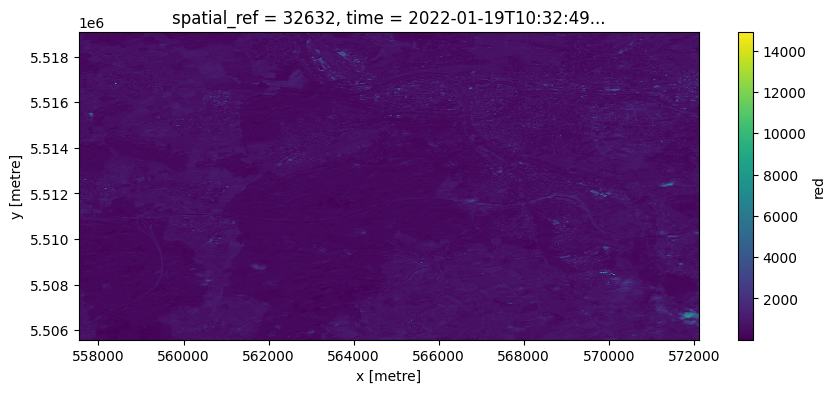

In [52]:
ds.red.isel(time=0).plot()

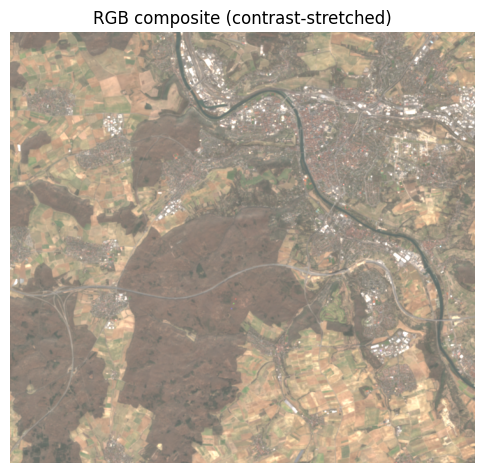

In [53]:
## Rescaling
for name in list(ds.data_vars):
    if name == "scl":
        continue
    ds[name] = ds[name].astype("float32") * 1e-4
ds

rgb = ds.isel(time=5)[["red", "green", "blue"]]
rgb_plot = xr.concat([rgb.red, rgb.green, rgb.blue], dim="band").transpose("y", "x", "band")

# Clip to [0, 0.3] and stretch to [0, 1] for display
rgb_display = np.clip(rgb_plot.values / 0.3, 0, 1)

plt.figure(figsize=(6, 6))
plt.imshow(rgb_display)
plt.title("RGB composite (contrast-stretched)")
plt.axis("off")
plt.show()


### Checkpoint (Part 1)

If you can do these without copy/pasting, you’re good:

1. **Change the AOI**: update `bbox` and re-run the search + load.
2. **Change the time window**: try a different month/season — does the cloud situation change?
3. **Tighten the search**: add / adjust a cloud-cover filter (or sorting) and observe the effect on results.
4. **Verify the mask**: compare `ds` vs `ds_clear` (pixel counts, quick RGB).

## Part 2 — Xarray-I: Data structure


### Agenda (Part 2)

- `xarray.Dataset` vs `xarray.DataArray` (and when to use which)
- Dimensions, coordinates, attributes (how EO metadata lives in xarray)
- Indexing & slicing: `sel` vs `isel`
- Reshaping between Dataset/DataArray representations

**By the end you should be able to**: navigate a dataset confidently and extract meaningful subsets without getting lost in dimensions.


### Xarray-I: Data Structure 

## Background

The Python library **`xarray`** is the form in which earth observation data are usually stored in a datacube.
It is an open source project and Python package which offers a toolkit for working with ***multi-dimensional arrays*** of data. Understanding the structure of a **`xarray.dataset`** is the key to enabling our work with these data. 

# **What is inside an `xarray.Dataset`?**

An `xarray.Dataset` is the Python representation of a **multi-dimensional datacube**. Think of it as a structured container that keeps pixel values, their coordinates, and metadata all in one object.

The diagram below maps the four key components to our Sentinel-2 dataset:

![xarray data structure](https://live.staticflickr.com/65535/51083605166_70dd29baa8_k.jpg)

### The four building blocks

| Component | What it is | Our dataset |
|-----------|-----------|-------------|
| **Data Variables** | Named arrays that hold the actual pixel values. Each variable shares the same dimensions. | `blue`, `green`, `red`, `nir`, `scl` |
| **Dimensions** (`dims`) | The axes of the array — they define its shape. | `time`, `y`, `x` |
| **Coordinates** (`coords`) | Label arrays along each dimension — they let you select data by real-world values instead of integer indices. | Timestamps along `time`, UTM northing along `y`, UTM easting along `x` |
| **Attributes** (`attrs`) | A dictionary of metadata (CRS, units, provenance, etc.). | `crs: EPSG:32632` |

### How do these relate?

```
Dataset  (container)
├── Dimensions:   time × y × x
├── Coordinates:  time = [2022-03-02, 2022-03-05, ...]
│                 y    = [5520000, 5519980, ...]
│                 x    = [568000, 568020, ...]
├── Data variables:
│     blue  (time, y, x)  →  3-D array of float32
│     green (time, y, x)  →  3-D array of float32
│     red   (time, y, x)  →  3-D array of float32
│     nir   (time, y, x)  →  3-D array of float32
│     scl   (time, y, x)  →  3-D array of uint16
└── Attributes:  {crs: "EPSG:32632", ...}
```


### `Dataset` vs `DataArray` — when to use which?

| | `Dataset` | `DataArray` |
|---|---|---|
| **Contains** | Multiple variables | One variable |
| **Use when** | You need several bands together (e.g., computing NDVI from `nir` and `red`) | You're working with a single quantity (e.g., plotting one band, computing a time series) |
| **Access** | `ds["red"]` or `ds.red` returns a DataArray | Already a DataArray |
| **Convert** | `ds.to_array(dim="band")` → stacks all variables into one DataArray | `da.to_dataset(dim="band")` → splits back into a Dataset |

Now let's deconstruct the dataset we have just loaded a bit further to have things more clarified!:D

In [54]:
# Display the full Dataset — click the arrows in the HTML repr to expand
ds

<xarray.Dataset> Size: 195MB
Dimensions:      (y: 676, x: 729, time: 22)
Coordinates:
  * y            (y) float64 5kB 5.519e+06 5.519e+06 ... 5.506e+06 5.506e+06
  * x            (x) float64 6kB 5.576e+05 5.576e+05 ... 5.721e+05 5.721e+05
  * time         (time) datetime64[us] 176B 2022-01-19T10:32:49.024000 ... 20...
    spatial_ref  int32 4B 32632
Data variables:
    blue         (time, y, x) float32 43MB 0.0232 0.0195 ... 0.1167 0.1169
    green        (time, y, x) float32 43MB 0.0342 0.0285 ... 0.1362 0.1354
    red          (time, y, x) float32 43MB 0.0417 0.0367 0.023 ... 0.115 0.1151
    nir          (time, y, x) float32 43MB 0.1265 0.1294 ... 0.4274 0.4347
    scl          (time, y, x) uint16 22MB 7 7 2 2 2 4 4 4 4 ... 4 4 4 4 4 4 4 4

In [55]:
# Data Variables 
# List all variable names (= the spectral bands we loaded)
list(ds.data_vars)


['blue', 'green', 'red', 'nir', 'scl']

In [56]:
# Pull out one variable → returns an xr.DataArray
da_red = ds["red"]
da_red

<xarray.DataArray 'red' (time: 22, y: 676, x: 729)> Size: 43MB
array([[[0.0417    , 0.0367    , 0.023     , ..., 0.054     ,
         0.07319999, 0.0854    ],
        [0.0171    , 0.0201    , 0.0177    , ..., 0.072     ,
         0.084     , 0.0695    ],
        [0.0227    , 0.0197    , 0.0219    , ..., 0.0815    ,
         0.0703    , 0.0433    ],
        ...,
        [0.0859    , 0.0875    , 0.0784    , ..., 0.0682    ,
         0.0966    , 0.1098    ],
        [0.0797    , 0.0928    , 0.074     , ..., 0.0946    ,
         0.13159999, 0.1374    ],
        [0.06879999, 0.0731    , 0.0772    , ..., 0.1068    ,
         0.12619999, 0.1274    ]],

       [[0.1581    , 0.1533    , 0.1414    , ..., 0.1612    ,
         0.16939999, 0.1848    ],
        [0.1336    , 0.1329    , 0.13      , ..., 0.1753    ,
         0.191     , 0.183     ],
        [0.13589999, 0.1299    , 0.1303    , ..., 0.1918    ,
         0.1894    , 0.1654    ],
...
        [0.2807    , 0.2877    , 0.31379998, ..., 0.1364    ,
         0.13769999, 0.14289999],
        [0.3502    , 0.34309998, 0.3601    , ..., 0.1245    ,
         0.12329999, 0.1241    ],
        [0.39      , 0.3854    , 0.3807    , ..., 0.12329999,
         0.12199999, 0.12159999]],

       [[0.1643    , 0.1515    , 0.139     , ..., 0.2767    ,
         0.1813    , 0.15359999],
        [0.1392    , 0.1352    , 0.13059999, ..., 0.21509999,
         0.1689    , 0.1568    ],
        [0.1362    , 0.1276    , 0.1245    , ..., 0.18069999,
         0.1806    , 0.1726    ],
        ...,
        [0.28419998, 0.2884    , 0.3173    , ..., 0.1325    ,
         0.1328    , 0.1382    ],
        [0.36159998, 0.3491    , 0.3645    , ..., 0.1191    ,
         0.11759999, 0.11759999],
        [0.4052    , 0.39769998, 0.3901    , ..., 0.11629999,
         0.11499999, 0.1151    ]]], shape=(22, 676, 729), dtype=float32)
Coordinates:
  * time         (time) datetime64[us] 176B 2022-01-19T10:32:49.024000 ... 20...
  * y            (y) float64 5kB 5.519e+06 5.519e+06 ... 5.506e+06 5.506e+06
  * x            (x) float64 6kB 5.576e+05 5.576e+05 ... 5.721e+05 5.721e+05
    spatial_ref  int32 4B 32632
Attributes:
    nodata:   0

In [57]:
# Dimensions
# dims tells you the axis names AND their lengths
ds.dims

FrozenMappingWarningOnValuesAccess({'y': 676, 'x': 729, 'time': 22})

Now let's deconstruct the dataset we have just loaded a bit further to have things more clarified!:D

In [58]:
# Coordinates 
# Coordinates are the labels along each dimension.

# Time coordinates are numpy datetime64 objects:
ds.time.values[:3]

# Spatial coordinates are in the CRS we chose (EPSG:32632 → metres):
print(f"\nx range: {float(ds.x.min()):.0f} – {float(ds.x.max()):.0f} m")
print(f"y range: {float(ds.y.min()):.0f} – {float(ds.y.max()):.0f} m")


x range: 557550 – 572110 m
y range: 5505590 – 5519090 m


## **Subsetting a Dataset / DataArray**

There are three ways to pull data out of an xarray object — each suited to a different situation:

| Method | Selects by | Example |
|--------|-----------|---------|
| **Positional `[]`** | Integer position along each axis (like NumPy) | `ds.blue[0, 0, 0]` |
| **`isel()`** | Integer position, but with **named** dimensions | `ds.blue.isel(time=0, y=0, x=0)` |
| **`sel()`** | Coordinate **labels** (dates, metres, …) | `ds.blue.sel(time="2022-03-10", method="nearest")` |

In [59]:
# Positional indexing 
# ds.blue has shape (time, y, x).
# [0]       → first time step      → 2-D (y × x)
# [0, 0]    → first time, first row → 1-D (x)
# [0, 0, 0] → single pixel          → scalar

print("All times:      ", ds.blue.shape)          # (time, y, x)
print("First time step:", ds.blue[0].shape)        # (y, x)
print("First row:      ", ds.blue[0, 0].shape)     # (x,)
print("Single pixel:   ", ds.blue[0, 0, 0].values) # scalar value

All times:       (22, 676, 729)
First time step: (676, 729)
First row:       (729,)
Single pixel:    0.0232


In [60]:
# isel: index by position, but with named dims ──────────────────
# Much clearer than ds.blue[0] — you see *which* axis you're slicing.
ds.blue.isel(time=0)

<xarray.DataArray 'blue' (y: 676, x: 729)> Size: 2MB
array([[0.0232    , 0.0195    , 0.0113    , ..., 0.0398    , 0.0476    ,
        0.054     ],
       [0.0118    , 0.0103    , 0.0092    , ..., 0.0489    , 0.0494    ,
        0.0444    ],
       [0.0139    , 0.0109    , 0.0111    , ..., 0.0503    , 0.0389    ,
        0.0343    ],
       ...,
       [0.0496    , 0.0495    , 0.0466    , ..., 0.0485    , 0.0689    ,
        0.0835    ],
       [0.0453    , 0.0548    , 0.0447    , ..., 0.07889999, 0.10879999,
        0.1072    ],
       [0.0382    , 0.0437    , 0.0475    , ..., 0.0898    , 0.1164    ,
        0.1098    ]], shape=(676, 729), dtype=float32)
Coordinates:
  * y            (y) float64 5kB 5.519e+06 5.519e+06 ... 5.506e+06 5.506e+06
  * x            (x) float64 6kB 5.576e+05 5.576e+05 ... 5.721e+05 5.721e+05
    spatial_ref  int32 4B 32632
    time         datetime64[us] 8B 2022-01-19T10:32:49.024000
Attributes:
    nodata:   0

In [61]:
# ── sel: index by coordinate labels ───────────────────────────────
# Use real-world values instead of integer offsets.

# Exact match (works because a time step exists on this date):
ds.blue.sel(time="2022-03-10")

<xarray.DataArray 'blue' (time: 1, y: 676, x: 729)> Size: 2MB
array([[[0.1511    , 0.14469999, 0.1355    , ..., 0.1512    ,
         0.1504    , 0.1604    ],
        [0.1317    , 0.1299    , 0.12789999, ..., 0.1572    ,
         0.1644    , 0.1612    ],
        [0.1311    , 0.126     , 0.1273    , ..., 0.16749999,
         0.1655    , 0.1537    ],
        ...,
        [0.1696    , 0.1704    , 0.1709    , ..., 0.14      ,
         0.1419    , 0.1437    ],
        [0.1786    , 0.1847    , 0.1803    , ..., 0.1317    ,
         0.1317    , 0.132     ],
        [0.1775    , 0.1854    , 0.1853    , ..., 0.13159999,
         0.132     , 0.133     ]]], shape=(1, 676, 729), dtype=float32)
Coordinates:
  * time         (time) datetime64[us] 8B 2022-03-10T10:27:39.025000
  * y            (y) float64 5kB 5.519e+06 5.519e+06 ... 5.506e+06 5.506e+06
  * x            (x) float64 6kB 5.576e+05 5.576e+05 ... 5.721e+05 5.721e+05
    spatial_ref  int32 4B 32632
Attributes:
    nodata:   0

In [62]:
# sel with method="nearest"
# When the exact timestamp/coordinate doesn't exist in the index:
ds.sel(time="2022-03-11", method="nearest")

# Works for spatial coords too (find the pixel closest to a UTM coordinate):
ds.sel(x=569_000, y=5_518_000, method="nearest")

<xarray.Dataset> Size: 592B
Dimensions:      (time: 22)
Coordinates:
  * time         (time) datetime64[us] 176B 2022-01-19T10:32:49.024000 ... 20...
    y            float64 8B 5.518e+06
    x            float64 8B 5.69e+05
    spatial_ref  int32 4B 32632
Data variables:
    blue         (time) float32 88B 0.0196 0.1173 0.1209 ... 0.1469 0.1437
    green        (time) float32 88B 0.0302 0.1344 0.1368 ... 0.1676 0.1621
    red          (time) float32 88B 0.0283 0.1353 0.1382 ... 0.1605 0.1551
    nir          (time) float32 88B 0.125 0.2407 0.2539 ... 0.4458 0.3914 0.3806
    scl          (time) uint16 44B 7 4 4 4 4 5 4 5 5 4 4 4 4 4 4 4 4 3 4 5 10 4

In [63]:
# Partial string indexing on time 
# Select all of March 2022 (any granularity works: year, month, day)
ds.sel(time="2022-03")

# Select a single day (returns all time steps on that day)
ds.sel(time="2022-03-10")

<xarray.Dataset> Size: 9MB
Dimensions:      (y: 676, x: 729, time: 1)
Coordinates:
  * y            (y) float64 5kB 5.519e+06 5.519e+06 ... 5.506e+06 5.506e+06
  * x            (x) float64 6kB 5.576e+05 5.576e+05 ... 5.721e+05 5.721e+05
  * time         (time) datetime64[us] 8B 2022-03-10T10:27:39.025000
    spatial_ref  int32 4B 32632
Data variables:
    blue         (time, y, x) float32 2MB 0.1511 0.1447 0.1355 ... 0.132 0.133
    green        (time, y, x) float32 2MB 0.1704 0.1619 0.1492 ... 0.1445 0.1456
    red          (time, y, x) float32 2MB 0.1887 0.1777 0.1605 ... 0.1494 0.1522
    nir          (time, y, x) float32 2MB 0.3197 0.2931 0.2599 ... 0.2443 0.2481
    scl          (time, y, x) uint16 986kB 5 5 5 5 5 4 4 4 4 ... 5 5 5 5 5 5 5 5

In [64]:
# Slicing multiple dimensions at once
# Spatial + temporal crop in one call
subset = ds.sel(
    time=slice("2022-03-05", "2022-03-20"),
    x=slice(568_000, 570_000),
    y=slice(5_520_000, 5_518_000),   # note: y often decreasing!
)
subset

<xarray.Dataset> Size: 199kB
Dimensions:      (y: 55, x: 100, time: 2)
Coordinates:
  * y            (y) float64 440B 5.519e+06 5.519e+06 ... 5.518e+06 5.518e+06
  * x            (x) float64 800B 5.68e+05 5.68e+05 5.68e+05 ... 5.7e+05 5.7e+05
  * time         (time) datetime64[us] 16B 2022-03-10T10:27:39.025000 2022-03...
    spatial_ref  int32 4B 32632
Data variables:
    blue         (time, y, x) float32 44kB 0.1569 0.1568 ... 0.1457 0.1413
    green        (time, y, x) float32 44kB 0.1834 0.1816 0.18 ... 0.1568 0.1503
    red          (time, y, x) float32 44kB 0.2152 0.2097 ... 0.1652 0.1567
    nir          (time, y, x) float32 44kB 0.2817 0.2888 ... 0.2353 0.2206
    scl          (time, y, x) uint16 22kB 5 5 5 5 5 5 5 5 5 ... 5 5 5 5 5 5 5 5

In [65]:
# Boolean / conditional indexing
# Keep only time steps where spatial-mean red reflectance > 0.05
mean_red = ds.red.mean(dim=["x", "y"])
ds.sel(time=mean_red > 0.05)

<xarray.Dataset> Size: 195MB
Dimensions:      (y: 676, x: 729, time: 22)
Coordinates:
  * y            (y) float64 5kB 5.519e+06 5.519e+06 ... 5.506e+06 5.506e+06
  * x            (x) float64 6kB 5.576e+05 5.576e+05 ... 5.721e+05 5.721e+05
  * time         (time) datetime64[us] 176B 2022-01-19T10:32:49.024000 ... 20...
    spatial_ref  int32 4B 32632
Data variables:
    blue         (time, y, x) float32 43MB 0.0232 0.0195 ... 0.1167 0.1169
    green        (time, y, x) float32 43MB 0.0342 0.0285 ... 0.1362 0.1354
    red          (time, y, x) float32 43MB 0.0417 0.0367 0.023 ... 0.115 0.1151
    nir          (time, y, x) float32 43MB 0.1265 0.1294 ... 0.4274 0.4347
    scl          (time, y, x) uint16 22MB 7 7 2 2 2 4 4 4 4 ... 4 4 4 4 4 4 4 4

In [66]:
# Select a single band as 
da_red = ds["red"]
da_red = ds.red

In [67]:
# Select a single band as DataArray vs. keep it in a Dataset 
da_red = ds["red"]          # → xr.DataArray
ds_red = ds[["red"]]        # → xr.Dataset with one variable (note double brackets)
print(type(da_red), type(ds_red))

<class 'xarray.core.dataarray.DataArray'> <class 'xarray.core.dataset.Dataset'>


In [68]:
# Drop a variable you don't need 
ds_no_scl = ds.drop_vars("scl")
ds_no_scl

<xarray.Dataset> Size: 173MB
Dimensions:      (y: 676, x: 729, time: 22)
Coordinates:
  * y            (y) float64 5kB 5.519e+06 5.519e+06 ... 5.506e+06 5.506e+06
  * x            (x) float64 6kB 5.576e+05 5.576e+05 ... 5.721e+05 5.721e+05
  * time         (time) datetime64[us] 176B 2022-01-19T10:32:49.024000 ... 20...
    spatial_ref  int32 4B 32632
Data variables:
    blue         (time, y, x) float32 43MB 0.0232 0.0195 ... 0.1167 0.1169
    green        (time, y, x) float32 43MB 0.0342 0.0285 ... 0.1362 0.1354
    red          (time, y, x) float32 43MB 0.0417 0.0367 0.023 ... 0.115 0.1151
    nir          (time, y, x) float32 43MB 0.1265 0.1294 ... 0.4274 0.4347

In [69]:
# where() with drop=True to shrink the array 
# Keep only pixels where NDVI > 0.3 and drop empty slices
ndvi = (ds.nir - ds.red) / (ds.nir + ds.red)
ds_veg = ds.where(ndvi > 0.3, drop=True)
print(f"Original shape: {dict(ds.dims)}")
print(f"After drop:     {dict(ds_veg.dims)}")

Original shape: {'y': 676, 'x': 729, 'time': 22}
After drop:     {'time': 22, 'y': 676, 'x': 729}


/var/folders/7x/v47p0s4s3bg3ytckj1t34h180000gn/T/ipykernel_5735/3033233189.py:5: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"Original shape: {dict(ds.dims)}")
/var/folders/7x/v47p0s4s3bg3ytckj1t34h180000gn/T/ipykernel_5735/3033233189.py:6: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"After drop:     {dict(ds_veg.dims)}")


### **Advanced Indexing**

#### By position (`isel` + `slice`)

Select the first five scenes. Remember: `slice(0, 5)` includes

In [70]:
# First 5 time steps by position
ds_first5 = ds.isel(time=slice(0, 5))
print(f"Selected {len(ds_first5.time)} of {len(ds.time)} time steps")
ds_first5.time.values

Selected 5 of 22 time steps


array(['2022-01-19T10:32:49.024000', '2022-02-13T10:31:31.024000',
       '2022-02-23T10:30:31.024000', '2022-02-28T10:28:49.024000',
       '2022-03-10T10:27:39.025000'], dtype='datetime64[us]')

#### II. By date label (`sel` + `slice`)

Select scenes between two dates. With `sel`, **both endpoints are included**.

In [73]:
# Date range — both bounds included
ds_march = ds.sel(time=slice("2022-03-01", "2022-04-10"))
print(f"Selected {len(ds_march.time)} scenes in range")
ds_march.time.values

Selected 5 scenes in range


array(['2022-03-10T10:27:39.025000', '2022-03-20T10:26:39.024000',
       '2022-03-22T10:17:11.024000', '2022-03-25T10:26:51.024000',
       '2022-03-27T10:16:29.024000'], dtype='datetime64[us]')

#### III. Datetime accessors (`.dt`)

xarray exposes a `.dt` accessor on datetime coordinates - useful for grouping, filtering, or labelling plots. The accessor mirrors the `pandas` datetime API.

| Accessor | Returns | Example output |
|----------|---------|----------------|
| `.dt.season` | Meteorological season | `"MAM"`, `"JJA"` |
| `.dt.month` | Month number (1-12) | `3`, `6` |
| `.dt.dayofyear` | Day of year (1-366) | `60`, `166` |
| `.dt.weekday` | Day of week (Mon=0) | `0`, `4` |

In [78]:
# Derive season and month from time coordinates
print("Seasons:\n", ds.time.dt.season.values)
print("\nMonths:\n", ds.time.dt.month.values)
print("\nDay of year:\n", ds.time.dt.dayofyear.values)

Seasons:
 ['DJF' 'DJF' 'DJF' 'DJF' 'MAM' 'MAM' 'MAM' 'MAM' 'MAM' 'MAM' 'MAM' 'MAM'
 'MAM' 'MAM' 'JJA' 'JJA' 'JJA' 'JJA' 'JJA' 'JJA' 'JJA' 'JJA']

Months:
 [1 2 2 2 3 3 3 3 3 4 4 5 5 5 6 6 6 6 6 7 7 7]

Day of year:
 [ 19  44  54  59  69  79  81  84  86 101 106 129 131 134 161 166 169 174
 179 184 201 206]


### Checkpoint (Part 2)

**Exercise 1 — Slice like a pro**

Select the `nir` band for **10 March 2022** using both `isel` and `sel`.
Compare the two results — are they identical?

<details>
<summary>Show solution</summary>

```python
# Find the integer index of 2022-03-10 first
time_vals = ds.time.values
idx = list(time_vals).index(np.datetime64('2022-03-10'))

# isel — by position
nir_isel = ds["nir"].isel(time=idx)

# sel — by label
nir_sel = ds["nir"].sel(time="2022-03-10")

print("isel shape:", nir_isel.shape)
print("sel  shape:", nir_sel.shape)
print("Identical?:", bool((nir_isel == nir_sel).all()))
```

</details>

---

**Exercise 2 — Spatial mean time series**

Compute the spatial mean of the `green` band at each time step (reduce over `x` and `y`).
Plot the resulting 1-D time series with `matplotlib`.

<details>
<summary>Show solution</summary>

```python
green_ts = ds["green"].mean(dim=["x", "y"])

plt.figure(figsize=(10, 3))
plt.plot(green_ts.time, green_ts.values, marker="o")
plt.xlabel("Time")
plt.ylabel("Mean green reflectance")
plt.title("Spatial-mean green band over time")
plt.tight_layout()
plt.show()
```

</details>


## Part 3 — Data Manipulation & Statistics

### Agenda (Part 3)

- **Reductions**: `min`, `max`, `mean`, `std` — with and without `dim`
- **Conditional operations**: `where()`, `isin()`, value replacement
- **Temporal resampling**: `resample()` and `groupby()`
- **Interpolation**: filling temporal gaps with `interp()` + `merge()`

**By the end you should be able to**: reduce a datacube along any axis, mask pixels by condition, and resample/interpolate in time.

### 1) Reductions

xarray's built-in reduction functions work like NumPy's — but you specify **dimension names** instead of axis numbers.

| Function | No `dim` (global) | `dim="time"` | `dim=["x", "y"]` |
|----------|-------------------|--------------|-------------------|
| `mean()` | Single scalar | One value per pixel (temporal mean) | One value per time step (spatial mean) |
| `std()` | Single scalar | Per-pixel variability | Per-scene variability |

In [80]:
# Global reduction (single number)
minr = ds.red.min()
maxr = ds.red.max()
print(f"Red band — min: {float(minr):.4f},  max: {float(maxr):.4f}")

Red band — min: 0.0001,  max: 1.6698


Result shape: {'time': 22}


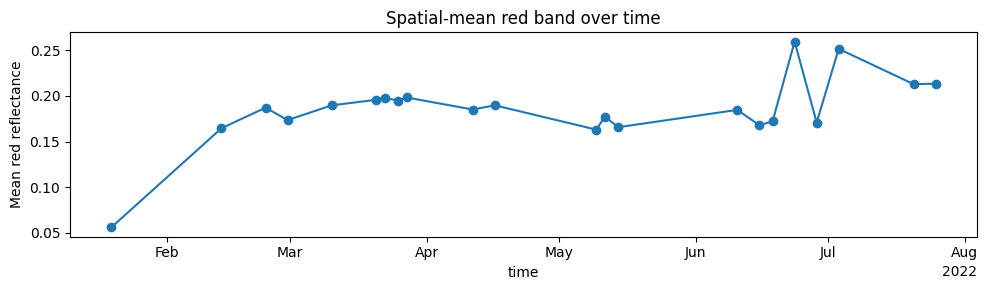

In [81]:
# Reduce over space → one value per time step 
red_ts = ds.red.mean(dim=["x", "y"])
print(f"Result shape: {dict(red_ts.sizes)}")  # only 'time' remains

# Quick plot
red_ts.plot(marker="o", figsize=(10, 3))
plt.ylabel("Mean red reflectance")
plt.title("Spatial-mean red band over time")
plt.tight_layout()
plt.show()

Result shape: {'y': 676, 'x': 729}


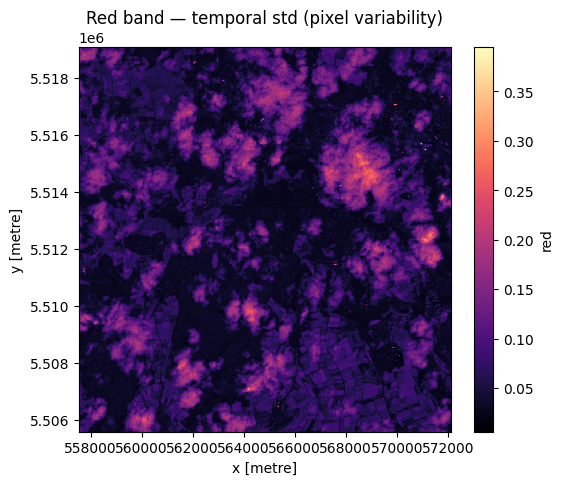

In [ ]:
# Reduce over time → one map
red_std = ds.red.std(dim="time")
print(f"Result shape: {dict(red_std.sizes)}")  # only 'y', 'x' remain

red_std.plot(figsize=(6, 5), cmap="magma")
plt.title("Red band — temporal std (pixel variability)")
plt.show()

In [83]:
#  .values extracts the raw NumPy array 
# Useful when you need to pass data to non-xarray code (sklearn, etc.)
blue_sum = ds.blue.sum(dim=["x", "y"]).values
print(f"Type: {type(blue_sum)}, shape: {blue_sum.shape}")
print(f"Values: {blue_sum}")

Type: <class 'numpy.ndarray'>, shape: (22,)
Values: [ 18690.938  65361.203  78063.34   72010.81   76400.25   78396.86
  76583.28   77046.75   79963.66   74669.94   79796.06   73097.586
  78494.06   72847.05   84327.25   75152.2    73499.31  123720.25
  73047.5   114792.81   82625.23   83555.5  ]


### 2) Conditional operations

| Method | What it does | Key arguments |
|--------|-------------|---------------|
| `where(cond)` | Keep values where `cond` is True; set others to `NaN` (or `other`) | `other=`, `drop=` |
| `isin(values)` | Element-wise test → boolean mask | — |

> **Gotcha**: `where()` keeps values where the condition is **True** and masks where it's **False**. This is the *opposite* of NumPy's `np.ma.masked_where`.

In [84]:
# where(): mask by condition 
# Keep only pixels with red reflectance > 0.07 (data is scaled 0–1)
ds_bright = ds.where(ds.red > 0.07)

# Count how many pixels survived vs. were masked (NaN)
total = ds.red.isel(time=0).size
valid = int(ds_bright.red.isel(time=0).count())
print(f"Pixels kept: {valid:,} / {total:,}  ({100*valid/total:.1f}%)")

Pixels kept: 116,648 / 492,804  (23.7%)


In [85]:
# where() with `drop=True`: physically shrink the array
# This was shown in Part 2 with NDVI — here's the pattern again:
ndvi = (ds.nir - ds.red) / (ds.nir + ds.red)
ds_veg = ds.where(ndvi > 0.3, drop=True)
print(f"Before: {dict(ds.dims)}")
print(f"After:  {dict(ds_veg.dims)}")

Before: {'y': 676, 'x': 729, 'time': 22}
After:  {'time': 22, 'y': 676, 'x': 729}


/var/folders/7x/v47p0s4s3bg3ytckj1t34h180000gn/T/ipykernel_5735/581643769.py:5: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"Before: {dict(ds.dims)}")
/var/folders/7x/v47p0s4s3bg3ytckj1t34h180000gn/T/ipykernel_5735/581643769.py:6: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"After:  {dict(ds_veg.dims)}")


Mask dtype: bool


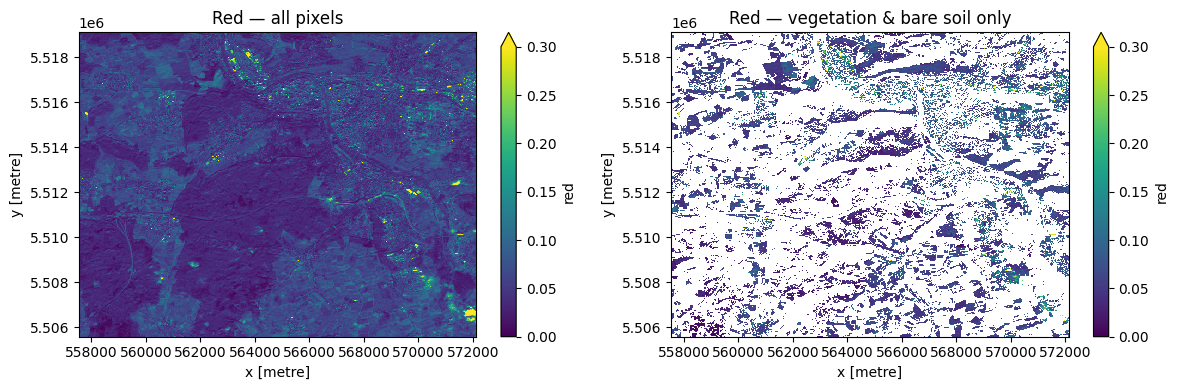

In [86]:
# isin(): build a mask from a set of values 
# Useful for categorical data like SCL (Scene Classification Layer)
# Keep only "vegetation" (4) and "bare soil" (5) classes
veg_soil_mask = ds.scl.isin([4, 5])
print(f"Mask dtype: {veg_soil_mask.dtype}")

# Apply the mask to the whole dataset
ds_clean = ds.where(veg_soil_mask)

# Show one time step
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ds.red.isel(time=0).plot(ax=ax1, vmin=0, vmax=0.3)
ax1.set_title("Red — all pixels")
ds_clean.red.isel(time=0).plot(ax=ax2, vmin=0, vmax=0.3)
ax2.set_title("Red — vegetation & bare soil only")
plt.tight_layout()
plt.show()

### 3) Temporal resampling

Resampling changes the **temporal granularity** of a datacube. It works like `pandas.DataFrame.resample()`: you specify a frequency string and then chain an aggregation.

| Frequency | String | Example |
|-----------|--------|---------|
| Month-end | `"ME"` | `ds.resample(time="ME").median()` |
| 2 weeks | `"2W"` | `ds.resample(time="2W").mean()` |
| Quarter | `"QE"` | `ds.resample(time="QE").max()` |

> **Note**: older xarray/pandas used `"M"` for monthly. Since pandas 2.2 this is deprecated — use `"ME"` instead.

In [87]:
# resample: monthly median composite 
ds_monthly = ds.resample(time="ME").median()
print(f"Original time steps: {len(ds.time)}")
print(f"Monthly composites:  {len(ds_monthly.time)}")
ds_monthly.time.values

Original time steps: 22
Monthly composites:  7


array(['2022-01-31T00:00:00.000000', '2022-02-28T00:00:00.000000',
       '2022-03-31T00:00:00.000000', '2022-04-30T00:00:00.000000',
       '2022-05-31T00:00:00.000000', '2022-06-30T00:00:00.000000',
       '2022-07-31T00:00:00.000000'], dtype='datetime64[us]')

#### `groupby()` — aggregate by calendar attribute

`groupby()` is similar but groups by a **categorical** time property (month, season) rather than producing contiguous bins.

| `resample()` | `groupby()` |
|-------------|------------|
| Produces a new time axis (one bin per interval) | Replaces time with the grouping variable (e.g., `month`) |
| Bins can be empty | Every group has ≥ 1 member |
| Good for compositing | Good for climatologies / seasonal means |

Result dims: {'month': 7, 'y': 676, 'x': 729}
Months present: [1 2 3 4 5 6 7]


/var/folders/7x/v47p0s4s3bg3ytckj1t34h180000gn/T/ipykernel_5735/3851458629.py:3: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"Result dims: {dict(ds_by_month.dims)}")   # 'month' replaces 'time'


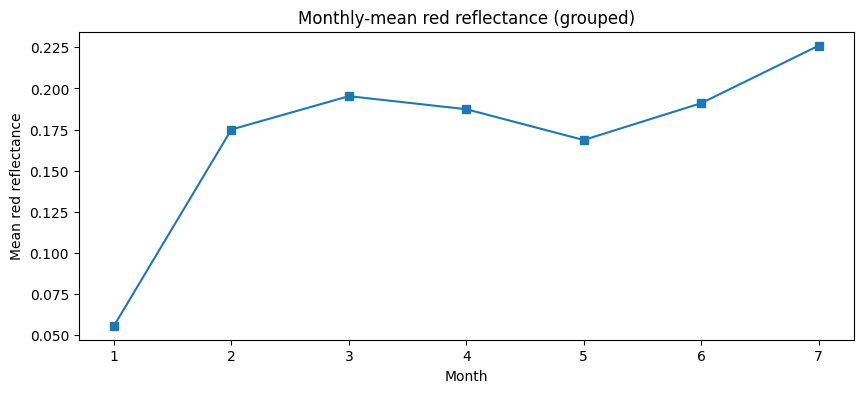

In [88]:
# groupby: mean per calendar month 
ds_by_month = ds.groupby("time.month").mean(dim="time")
print(f"Result dims: {dict(ds_by_month.dims)}")   # 'month' replaces 'time'
print(f"Months present: {ds_by_month.month.values}")

# Plot the monthly mean red reflectance (spatially averaged)
ds_by_month.red.mean(dim=["x", "y"]).plot(marker="s")
plt.xlabel("Month")
plt.ylabel("Mean red reflectance")
plt.title("Monthly-mean red reflectance (grouped)")
plt.show()

### 4) Interpolation

Cloud cover and revisit gaps mean some dates have no observation. `interp()` fills these by interpolating between the nearest available time steps (default: linear).

**Workflow**: `interp()` → new dataset at the requested date → `merge()` to splice it back in.

In [89]:
# Check existing time steps — pick a gap to fill
print("Available dates:")
for t in ds.time.values:
    print(f"  {str(t)[:10]}")

Available dates:
  2022-01-19
  2022-02-13
  2022-02-23
  2022-02-28
  2022-03-10
  2022-03-20
  2022-03-22
  2022-03-25
  2022-03-27
  2022-04-11
  2022-04-16
  2022-05-09
  2022-05-11
  2022-05-14
  2022-06-10
  2022-06-15
  2022-06-18
  2022-06-23
  2022-06-28
  2022-07-03
  2022-07-20
  2022-07-25


In [93]:
# ── Interpolate to a date that falls between existing time steps ──
# Pick a date inside our time range but NOT in the index
# (adjust this date to sit between two of your actual time steps)

target_date = np.datetime64("2022-03-07")

# Only interpolate numeric bands (exclude categorical SCL)
ds_numeric = ds.drop_vars("scl")
ds_interp = ds_numeric.interp(time=[target_date])

print(f"Interpolated to: {ds_interp.time.values}")
print(f"Red spatial mean: {float(ds_interp.red.mean()):.4f}")

Interpolated to: ['2022-03-07T00:00:00']
Red spatial mean: 0.1841


In [94]:
# Merge interpolated scene back into the time series
ds_extended = ds_numeric.merge(ds_interp)
print(f"Before: {len(ds_numeric.time)} time steps")
print(f"After:  {len(ds_extended.time)} time steps")

# Verify the new date appears in sorted order
print(f"\nTime axis:\n{ds_extended.time.values}")

Before: 22 time steps
After:  23 time steps

Time axis:
['2022-01-19T10:32:49.024000' '2022-02-13T10:31:31.024000'
 '2022-02-23T10:30:31.024000' '2022-02-28T10:28:49.024000'
 '2022-03-07T00:00:00.000000' '2022-03-10T10:27:39.025000'
 '2022-03-20T10:26:39.024000' '2022-03-22T10:17:11.024000'
 '2022-03-25T10:26:51.024000' '2022-03-27T10:16:29.024000'
 '2022-04-11T10:16:01.024000' '2022-04-16T10:15:59.024000'
 '2022-05-09T10:25:59.024000' '2022-05-11T10:16:01.024000'
 '2022-05-14T10:26:01.025000' '2022-06-10T10:16:11.024000'
 '2022-06-15T10:15:59.025000' '2022-06-18T10:25:59.024000'
 '2022-06-23T10:30:31.024000' '2022-06-28T10:26:09.025000'
 '2022-07-03T10:26:11.024000' '2022-07-20T10:16:11.024000'
 '2022-07-25T10:15:59.024000']


/var/folders/7x/v47p0s4s3bg3ytckj1t34h180000gn/T/ipykernel_5735/2014396283.py:2: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'time' ('time',) The recommendation is to set join explicitly for this case.
  ds_extended = ds_numeric.merge(ds_interp)
/var/folders/7x/v47p0s4s3bg3ytckj1t34h180000gn/T/ipykernel_5735/2014396283.py:2: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds_extended = ds_numeric.merge(ds_interp)
/var/folde

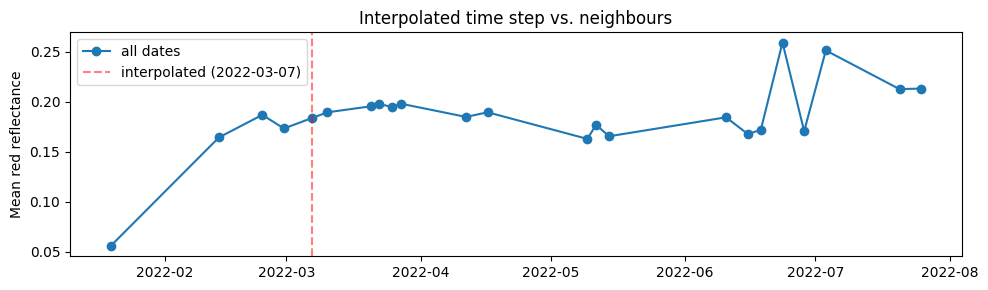

In [95]:
# ── Sanity check: compare interpolated vs. neighbours ─────────────
# The interpolated value should fall between its two neighbours
red_ts = ds_extended.red.mean(dim=["x", "y"])

fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(red_ts.time, red_ts.values, "o-", label="all dates")
ax.axvline(np.datetime64(target_date), color="red", ls="--", alpha=0.5, label=f"interpolated ({target_date})")
ax.legend()
ax.set_ylabel("Mean red reflectance")
ax.set_title("Interpolated time step vs. neighbours")
plt.tight_layout()
plt.show()

> ⚠️ **Never interpolate categorical data** (like SCL). `interp()` does linear math — applying it to class labels produces nonsense. Always `drop_vars("scl")` first, or interpolate only the bands you need.

For more xarray functions see the [official documentation](https://docs.xarray.dev/en/stable/).

### Checkpoint (Part 3)

**Exercise 1 — Monthly composite**

Produce a monthly **mean** composite (instead of median). How many time steps does the result have? Plot the spatial-mean NIR for each month.

<details>
<summary>Show solution</summary>

```python
ds_monthly_mean = ds.resample(time="ME").mean()
print(f"Monthly composites: {len(ds_monthly_mean.time)}")

ds_monthly_mean.nir.mean(dim=["x", "y"]).plot(marker="o")
plt.ylabel("Mean NIR reflectance")
plt.title("Monthly-mean NIR")
plt.show()
```

</details>

---

**Exercise 2 — SCL masking**

Use `isin()` on the `scl` band to keep only vegetation pixels (class 4). Apply the mask with `where()` and compute the temporal mean of NDVI for the masked pixels. Plot the result as a map.

<details>
<summary>Show solution</summary>

```python
veg_mask = ds.scl.isin([4])
ndvi = (ds.nir - ds.red) / (ds.nir + ds.red)
ndvi_veg = ndvi.where(veg_mask).mean(dim="time")

ndvi_veg.plot(figsize=(6, 5), cmap="YlGn", vmin=0, vmax=0.8)
plt.title("Mean NDVI — vegetation pixels only")
plt.show()
```

</details>

---

**Exercise 3 — Interpolation sanity check**

Interpolate to a date between two existing time steps. Extract the spatial-mean red value for (a) the date before, (b) the interpolated date, and (c) the date after. Verify that the interpolated value falls between the two neighbours.

<details>
<summary>Show solution</summary>

```python
# Pick dates (adjust to your actual time steps)
before = ds.red.sel(time="2022-03-05", method="nearest").mean(dim=["x", "y"])
after  = ds.red.sel(time="2022-03-10", method="nearest").mean(dim=["x", "y"])

ds_num = ds.drop_vars("scl")
interp = ds_num.interp(time=["2022-03-07"]).red.mean(dim=["x", "y"])

print(f"Before:       {float(before):.4f}")
print(f"Interpolated: {float(interp):.4f}")
print(f"After:        {float(after):.4f}")
print(f"Between?      {float(min(before, after)) <= float(interp) <= float(max(before, after))}")
```

</details>